# Forest Fire Prediction

## Imports

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import shap

## Dataset

In [22]:
df = pd.read_csv('forest_fire_dataset.csv')
df['Date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.drop(columns=['day', 'month', 'year', 'Classes', 'Region'], inplace=True)
df.set_index('Date', inplace=True)

df.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
Date,,,,,,,,,,
2012-06-01,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5
2012-06-02,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4
2012-06-03,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1
2012-06-04,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0
2012-06-05,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5


In [23]:
df.shape

(243, 10)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243 entries, 2012-06-01 to 2012-09-30
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  243 non-null    int64  
 1   RH           243 non-null    int64  
 2   Ws           243 non-null    int64  
 3   Rain         243 non-null    float64
 4   FFMC         243 non-null    float64
 5   DMC          243 non-null    float64
 6   DC           243 non-null    float64
 7   ISI          243 non-null    float64
 8   BUI          243 non-null    float64
 9   FWI          243 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 20.9 KB


In [25]:
df.isnull().sum()

Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
dtype: int64

In [26]:
summary = df.describe().transpose().round(2)
summary

,count,mean,std,min,25%,50%,75%,max
Temperature,243.0,32.15,3.63,22.0,30.00,32.0,35.00,42.0
RH,243.0,62.04,14.83,21.0,52.50,63.0,73.50,90.0
Ws,243.0,15.49,2.81,6.0,14.00,15.0,17.00,29.0
Rain,243.0,0.76,2.00,0.0,0.00,0.0,0.50,16.8
FFMC,243.0,77.84,14.35,28.6,71.85,83.3,88.30,96.0
DMC,243.0,14.68,12.39,0.7,5.80,11.3,20.80,65.9
DC,243.0,49.43,47.67,6.9,12.35,33.1,69.10,220.4
ISI,243.0,4.74,4.15,0.0,1.40,3.5,7.25,19.0
BUI,243.0,16.69,14.23,1.1,6.00,12.4,22.65,68.0
FWI,243.0,7.04,7.44,0.0,0.70,4.2,11.45,31.1


## Linear Regression Model

In [27]:
X = df.drop('FWI', axis=1)
y = df['FWI']

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.20, random_state=42)

X_train.shape, X_test.shape

((194, 9), (49, 9))

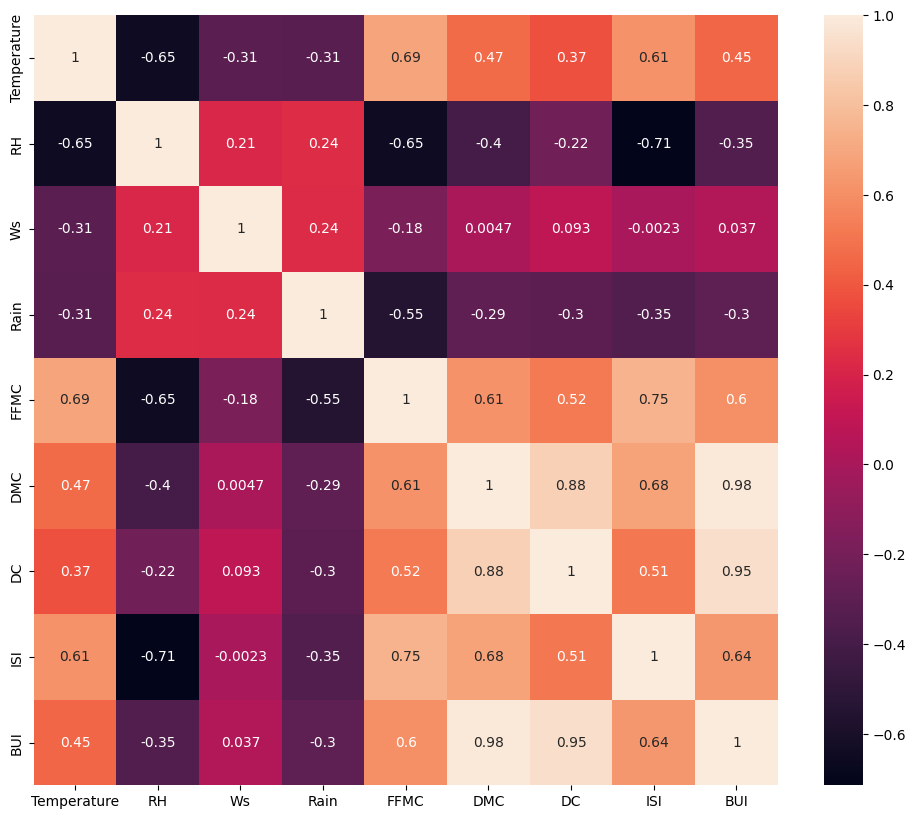

In [28]:
plt.figure(figsize=(12,10))
sns.heatmap(X_train.corr(), annot=True)
plt.show()

# TODO: Multikolinearität, Feature Scaling

In [29]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
train_score = linreg.score(X_train, y_train)
test_score = r2_score(y_test, y_pred)

print("Mean absolute error: ", mae)
print("Mean squared error:  ", mse)
print("Train R2 score:      ", train_score)
print("Test R2 Score:       ", test_score)


Mean absolute error:  0.4240179386916396
Mean squared error:   0.35543638257764515
Train R2 score:       0.973083838832041
Test R2 Score:        0.9882726857720829


In [30]:
cdf = pd.DataFrame(linreg.coef_.round(5), X_train.columns, columns=['Coefficients'])
cdf.loc['Intercept'] = linreg.intercept_.round(5)
cdf

,Coefficients
Temperature,-0.01871
RH,-0.00522
Ws,-0.03585
Rain,0.01507
FFMC,-0.05101
DMC,0.01017
DC,-0.00634
ISI,1.21311
BUI,0.26293
Intercept,2.48876


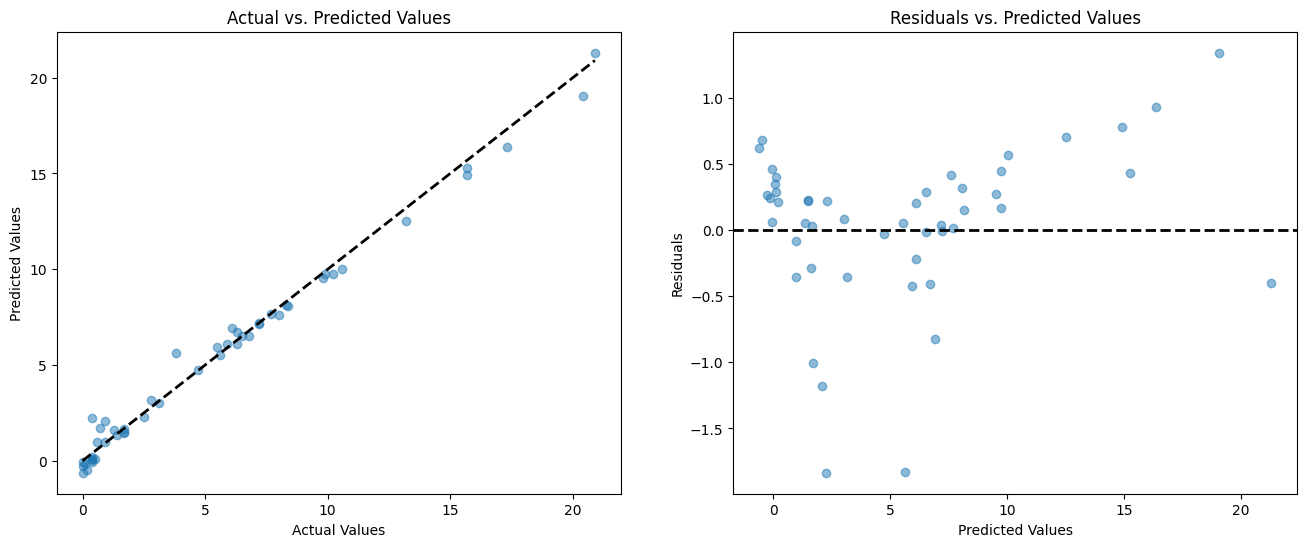

In [37]:
residuals = y_test - y_pred

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].scatter(y_test, y_pred, alpha=0.5)
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', linewidth=2)
axs[0].set_title('Actual vs. Predicted Values')
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')

axs[1].scatter(y_pred, residuals, alpha=0.5)
axs[1].axhline(y=0, color='k', linestyle='--', linewidth=2)
axs[1].set_title('Residuals vs. Predicted Values')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')

plt.show()

## Shapley Charts

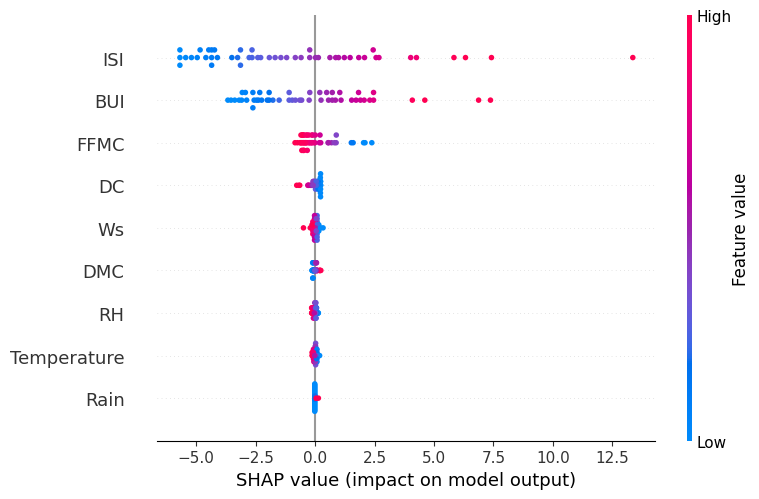

In [39]:
explainer = shap.Explainer(linreg, X_train, algorithm='linear')
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

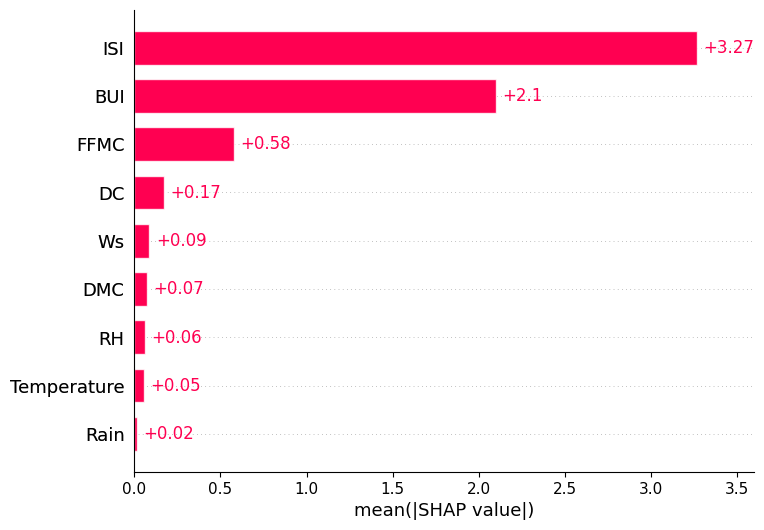

In [32]:
shap.plots.bar(shap_values)

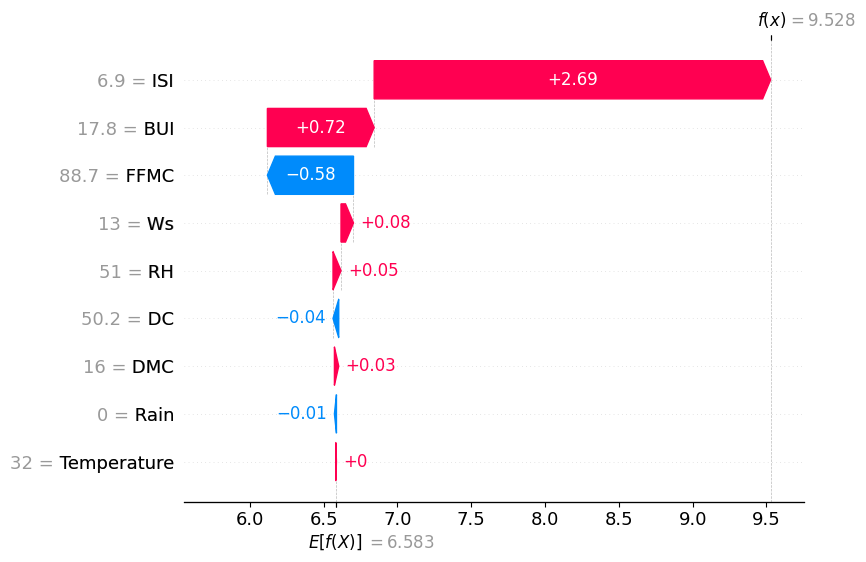

In [33]:
sample_ind = 12
shap.plots.waterfall(shap_values[sample_ind])

In [34]:
shap.plots.force(shap_values[sample_ind])

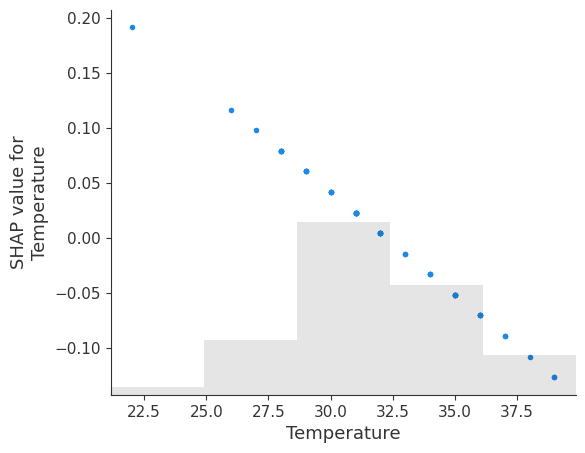

In [35]:
shap.plots.scatter(shap_values[:, "Temperature"])

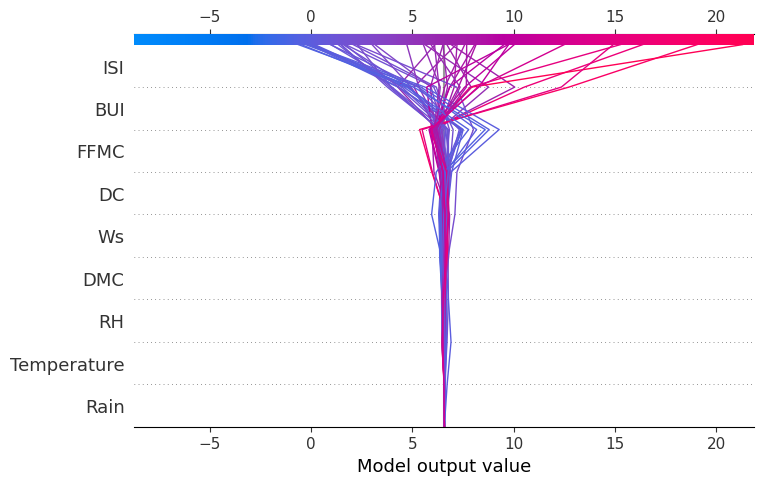

In [36]:
shap.decision_plot(explainer.expected_value, shap_values.values, X_test)
